In [1]:
# Imports:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import os
import time
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM


In [22]:
# Initialisation:

nshells=51

path_in = '/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/BCM/dmb_Mc2e14/fullsky_den/'
directory_contents = os.listdir(path_in)
print("*** original mass sheets ***")
print(directory_contents)

#path_out = '../../density/'
#directory_contents = os.listdir(path_out)
#print("*** new mass sheets ***")
#print(directory_contents)

path_out_tidal = '/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/BCM/dmb_Mc2e14/tidalfield/'
directory_contents = os.listdir(path_out_tidal)
print("*** tidal fields ***")
print(directory_contents)


zfile=np.loadtxt("z2ts_HACCY1_51.txt",delimiter=' ')
snaplist = zfile[:,0].astype(int)
zlist=zfile[:,1]

cosmo = FlatLambdaCDM(H0=71, Om0=0.2648, Tcmb0=2.725)

#include a 0.1Mpc/h smoothing, expressed here in Mpc (not Mpc/h):
#smoothing_comoving = 0.1/cosmo.h*u.Mpc
#Also computing a 0.5Mpc/h smoothing, expressed here in Mpc (not Mpc/h):
smoothing_comoving = 0.5/cosmo.h*u.Mpc
#Also computing a 1.0Mpc/h smoothing, expressed here in Mpc (not Mpc/h):
#smoothing_comoving = 1.0/cosmo.h*u.Mpc
print("smoothing the field with", smoothing_comoving, "(e.g. not Mpc/h)")



*** original mass sheets ***
['density_map_50_dens_allsky.npy', 'density_map_06_dens_allsky.npy', 'density_map_32_dens_allsky.npy', 'density_map_18_dens_allsky.npy', 'density_map_34_dens_allsky.npy', 'density_map_01_dens_allsky.npy', 'density_map_40_dens_allsky.npy', 'density_map_11_dens_allsky.npy', 'density_map_44_dens_allsky.npy', 'density_map_26_dens_allsky.npy', 'density_map_39_dens_allsky.npy', 'density_map_46_dens_allsky.npy', 'density_map_19_dens_allsky.npy', 'density_map_08_dens_allsky.npy', 'density_map_00_dens_allsky.npy', 'density_map_21_dens_allsky.npy', 'density_map_07_dens_allsky.npy', 'density_map_43_dens_allsky.npy', 'density_map_49_dens_allsky.npy', 'density_map_33_dens_allsky.npy', 'density_map_47_dens_allsky.npy', 'density_map_23_dens_allsky.npy', 'density_map_16_dens_allsky.npy', 'density_map_17_dens_allsky.npy', 'density_map_25_dens_allsky.npy', 'density_map_20_dens_allsky.npy', 'density_map_28_dens_allsky.npy', 'density_map_35_dens_allsky.npy', 'density_map_10_de

In [9]:
def compute_tidal_tensor_spherical_new(hpmap, smoothing):

    #-----------------------
    # Get alm from delta map:
    print("starting delta map2alm")
    #The input maps must all be in ring ordering.
    
    delta=np.copy(hpmap)
    
    alm_E = hp.sphtfunc.map2alm(hpmap, lmax=5000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    alm_B = alm_E*0.0;
    print("Done forward transform")
    
    if (smoothing > 0.0) :
        #smooth by sigma, given in radians
        print("smoothing by beam with sigma = "+str(smoothing)+"rad")
        alm_E_smooth=hp.sphtfunc.smoothalm(alm_E, fwhm=0.0, sigma=smoothing, beam_window=None, pol=False, mmax=None, verbose=True, inplace=True)
        alm_E = alm_E_smooth
        del alm_E_smooth
        print("Done Smoothing")
      
    print("Starting tidal alm2map")
    nside=hp.get_nside(hpmap)
    start = time.time()
    maps_QU = hp.alm2map_spin((alm_E, alm_B), nside, spin=2,lmax=5000,mmax=None)
    
    print("Got QU maps")
    end = time.time()
    print(end - start)

    # In 2D cartesian, s11(k)+s22(k)=delta(k)
    # In the spherical polarization framework, we have:
    # Q is 'g1' = (t11 - t22)
    # delta is t11 + t22
    # U is 'g2' = t12
    # t11 is (Q +delta)/2
    # t22 is (delta-Q)/2
    # Need to subtract off the trace, affecting s_11 and s_22...
    
    tidal_tensor_sph = np.zeros((hp.nside2npix(nside),3),dtype=np.float32)

    #t11 
    tidal_tensor_sph[:,0] = (maps_QU[0]+delta)/2.0 - 1./3 * hpmap
    
    #t22
    tidal_tensor_sph[:,1] = (delta-maps_QU[0])/2.0 - 1./3 * hpmap
 
    #t12
    tidal_tensor_sph[:,2] = maps_QU[1]

    print("Done!")         
    
    return tidal_tensor_sph    


loading map /global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/BCM/dmb_Mc2e14/fullsky_den/density_map_01_dens_allsky.npy
over density: -1.0 2203.9854 -2.7461404e-06


/tmp/ipykernel_292748/3086427035.py:20: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(binmap), nest=False)


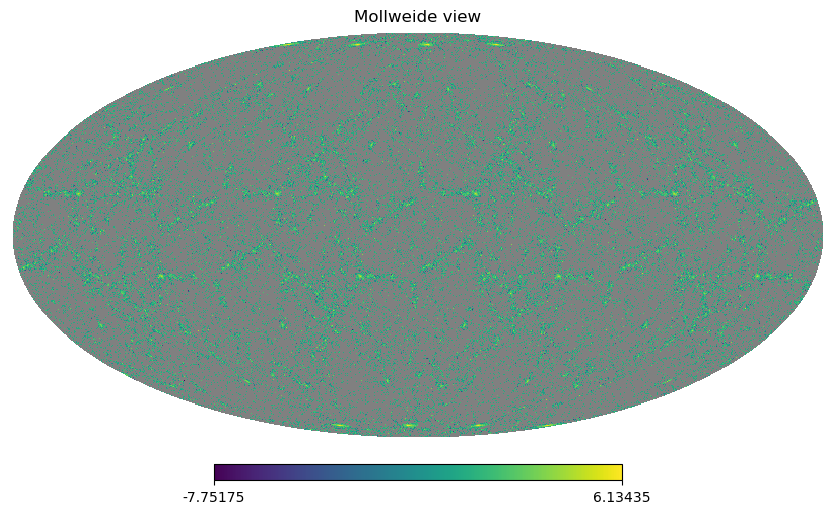

/tmp/ipykernel_292748/3086427035.py:25: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(binmap), cbar=True, lonra=lonra, latra=latra,


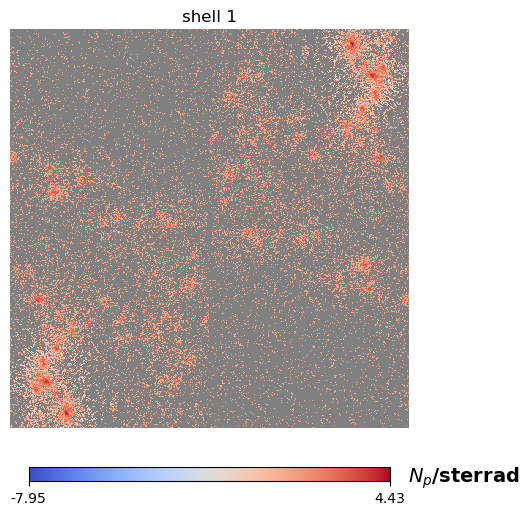

0.016177957532861553
68.08976452542754 Mpc
smoothing= 0.010342602254846824  rad, = 35.555247503112696  arcmin
starting delta map2alm
Done forward transform
smoothing by beam with sigma = 0.010342602254846824rad
Done Smoothing
Starting tidal alm2map


/tmp/ipykernel_292748/2346581508.py:17: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  alm_E_smooth=hp.sphtfunc.smoothalm(alm_E, fwhm=0.0, sigma=smoothing, beam_window=None, pol=False, mmax=None, verbose=True, inplace=True)


Got QU maps
76.16788983345032
Done!
Applied mask
s11: -12.290895 369.25092 -0.006070305
s22: -11.99069 365.41083 0.0060555874
s12: -24.65976 23.681978 -2.8132265e-06


/tmp/ipykernel_292748/3086427035.py:87: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(s[:,0]), nest=False)
/tmp/ipykernel_292748/3086427035.py:87: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(s[:,0]), nest=False)


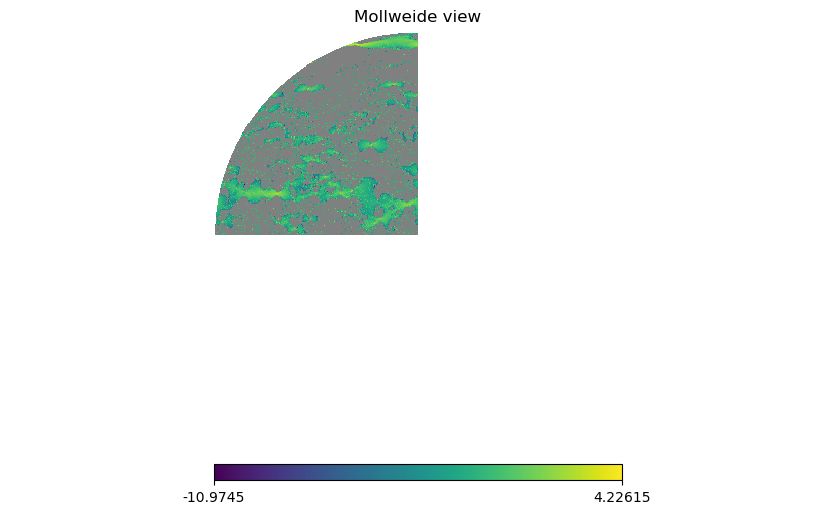

/tmp/ipykernel_292748/3086427035.py:91: RuntimeWarning: divide by zero encountered in log
  hp.cartview(np.log(s[:,0]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_292748/3086427035.py:91: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(s[:,0]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_292748/3086427035.py:100: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(s[:,1]), nest=False)
/tmp/ipykernel_292748/3086427035.py:100: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(s[:,1]), nest=False)


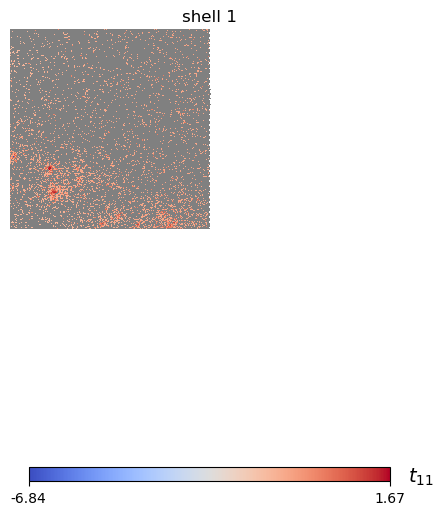

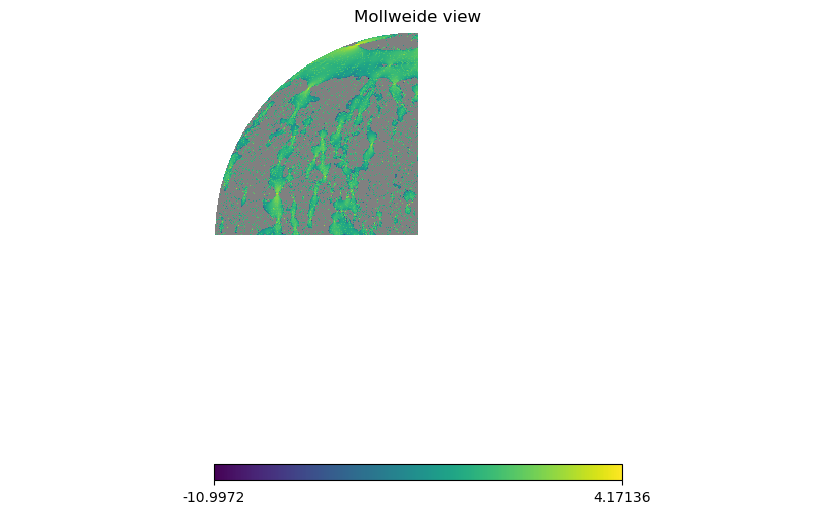

/tmp/ipykernel_292748/3086427035.py:104: RuntimeWarning: divide by zero encountered in log
  hp.cartview(np.log(s[:,1]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_292748/3086427035.py:104: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(s[:,1]), cbar=True, lonra=lonra, latra=latra,


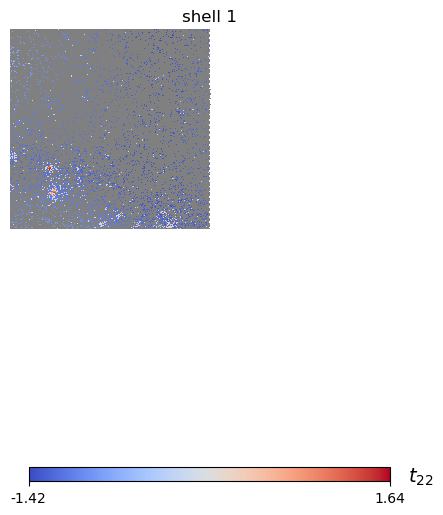

/tmp/ipykernel_292748/3086427035.py:114: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(s[:,2]), nest=False)
/tmp/ipykernel_292748/3086427035.py:114: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(s[:,2]), nest=False)


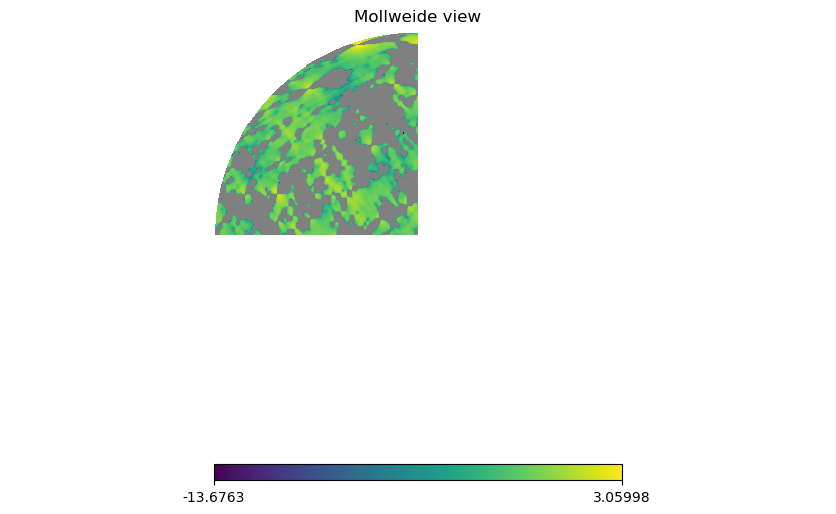

/tmp/ipykernel_292748/3086427035.py:119: RuntimeWarning: divide by zero encountered in log
  hp.cartview(np.log(s[:,2]), cbar=True, lonra=lonra, latra=latra,
/tmp/ipykernel_292748/3086427035.py:119: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(s[:,2]), cbar=True, lonra=lonra, latra=latra,


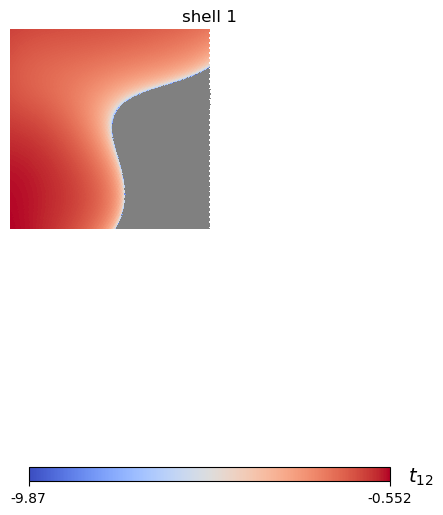

Saved s
loading map /global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/BCM/dmb_Mc2e14/fullsky_den/density_map_02_dens_allsky.npy
over density: -1.0 730.5523 -1.5431773e-06


/tmp/ipykernel_292748/3086427035.py:20: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(binmap), nest=False)


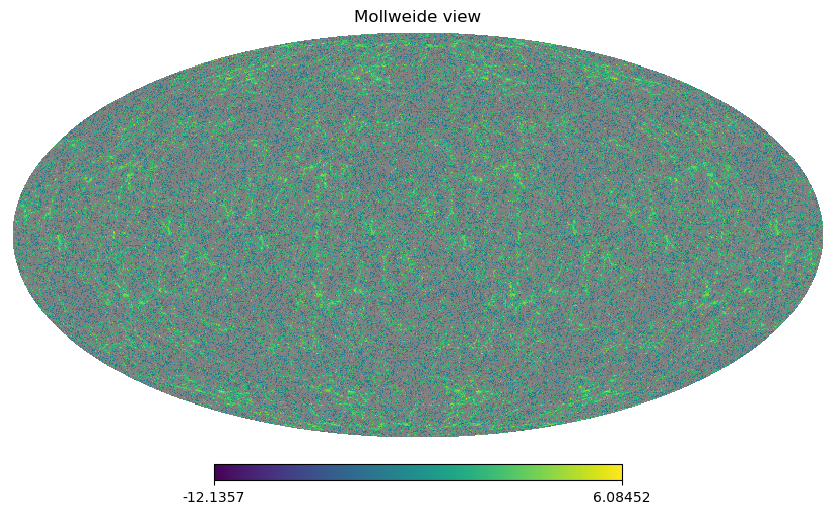

/tmp/ipykernel_292748/3086427035.py:25: RuntimeWarning: divide by zero encountered in log
  hp.cartview(np.log(binmap), cbar=True, lonra=lonra, latra=latra,


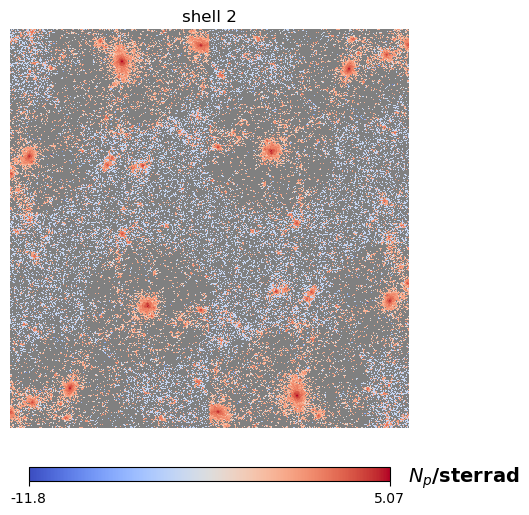

0.03288797533401855
137.9519318834117 Mpc
smoothing= 0.0051048603850495046  rad, = 17.549217304011897  arcmin
starting delta map2alm


In [ ]:


# Load full-sky density maps from file, compute tidal tensor, save
# Repeat for all redshifts

for snap in range(0,nshells):

    fname = path_in+'density_map_'+str(snaplist[snap]).zfill(2)+'_dens_allsky.npy'
    print("loading map", fname)
    binmap = np.load(fname)

    # Normalize the maps correctly:       
    mean_rho = (np.mean(binmap)) # no factor of 8.0 since we have full sky data here
    binmap /= mean_rho 
    binmap -= 1
    print("over density:",np.min(binmap), np.max(binmap), np.mean(binmap))


    
    
    # Visualize:
    hp.mollview(np.log(binmap), nest=False)
    plt.show()

    lonra = [-3, 3]
    latra = [-3, 3]
    hp.cartview(np.log(binmap), cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$N_{p}$/sterrad')
    plt.show()
    
    # convert smoothing scale to anguar scales:
    shell_distance = cosmo.comoving_distance(zlist[snap]) #expressed here in Mpc as well (not Mpc/h):
    print(zlist[snap])
    print(shell_distance)

    smoothing_angular = smoothing_comoving/shell_distance
    print("smoothing=", smoothing_angular, " rad, =", smoothing_angular*180/np.pi*60, " arcmin")

    s = compute_tidal_tensor_spherical_new(binmap,smoothing=smoothing_angular)
    #s11,s22,s12,g1,g2 = compute_tidal_tensor_spherical_new(binmap,smoothing=smoothing_angular)
    
    #print("s11:",np.min(s11), np.max(s11), np.mean(s11))
    #print("s22:",np.min(s22), np.max(s22), np.mean(s22))
    #print("s12:",np.min(s12), np.max(s12), np.mean(s12))
    #print("g1:",np.min(g1), np.max(g1), np.mean(g1))
    #print("g2:",np.min(g2), np.max(g2), np.mean(g2))
 
    #nside=hp.get_nside(binmap)
    
    #something is wrong with the tensor notation...
    #s = np.zeros((hp.nside2npix(nside),3),dtype=np.float32)
    #s[:,0] = s11
    #s[:,1] = s22
    #s[:,2] = s12  

    #Apply mask to select just the octant.
    fname = 'mask_allsky.npy'
    octant_mask= np.load(fname)
    
    s[:,0] *= octant_mask
    s[:,1] *= octant_mask
    s[:,2] *= octant_mask

    #s11 *= octant_mask
    #s22 *= octant_mask
    #s12 *= octant_mask

    print("Applied mask")

    print("s11:",np.min(s[:,0]), np.max(s[:,0]), np.mean(s[:,0]))
    print("s22:",np.min(s[:,1]), np.max(s[:,1]), np.mean(s[:,1]))
    print("s12:",np.min(s[:,2]), np.max(s[:,2]), np.mean(s[:,2]))

    #print("s11:",np.min(s11), np.max(s11), np.mean(s11))
    #print("s22:",np.min(s22), np.max(s22), np.mean(s22))
    #print("s12:",np.min(s12), np.max(s12), np.mean(s12))

  
    
    # Visualize:
    lonra = [-3, 3]
    latra = [-3, 3]

    #hp.mollview(np.log(s11), nest=False)
    hp.mollview(np.log(s[:,0]), nest=False)
    plt.show()


    hp.cartview(np.log(s[:,0]), cbar=True, lonra=lonra, latra=latra,
    #hp.cartview(np.log(s11), cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$t_{11}$')


    hp.mollview(np.log(s[:,1]), nest=False)
    #hp.mollview(np.log(s22), nest=False)
    plt.show()

    hp.cartview(np.log(s[:,1]), cbar=True, lonra=lonra, latra=latra,
    #hp.cartview(np.log(s22), cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$t_{22}$')
    plt.show()


    hp.mollview(np.log(s[:,2]), nest=False)
    #hp.mollview(np.log(s12), nest=False)
    plt.show()


    hp.cartview(np.log(s[:,2]), cbar=True, lonra=lonra, latra=latra,
    #hp.cartview(np.log(s12), cbar=True, lonra=lonra, latra=latra,
            nest=False,
                title="shell "+str(snap),
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$t_{12}$')
    plt.show()

    #fname = path_out_tidal+'tidal_field_map_'+np.str(snaplist[snap])+'_allsky_smooth_1Mpc.npy'
    fname = path_out_tidal+'tidal_field_map_'+str(snaplist[snap])+'_allsky_smooth_05Mpc.npy'
    np.save(fname,s)

    print("Saved s")

In [42]:
snap=7
# Load mass sheet. Each is map is 114Mpc/.h, thick, see CosmoDC2 paper
data_file = path_in+'density_map_'+str(snaplist[snap])+'_dens.bin'
print('Working on file '+data_file)
tmp = np.fromfile(data_file,'<f')

# Format is nested, order into ring in order to use alm2maps transforms
# and degrade NSIDE 
print("NSIDE_orig=", hp.get_nside(tmp))
binmap=hp.pixelfunc.ud_grade(tmp, 4096, pess=False, order_in='NESTED', order_out='RING', power=None, dtype=None)

mask = np.load('mask_allsky.npy')
mask = hp.pixelfunc.ma(mask, badval=0, rtol=1e-05, atol=1e-08, copy=True)

Working on file /global/cfs/cdirs/lsst/groups/CS/mass_sheets/density_map_421_dens.bin
NSIDE_orig= 8192


/tmp/ipykernel_1812073/2585666929.py:2: RuntimeWarning: divide by zero encountered in log10
  hp.orthview(np.log10(binmap*mask+1),rot=(35,20),


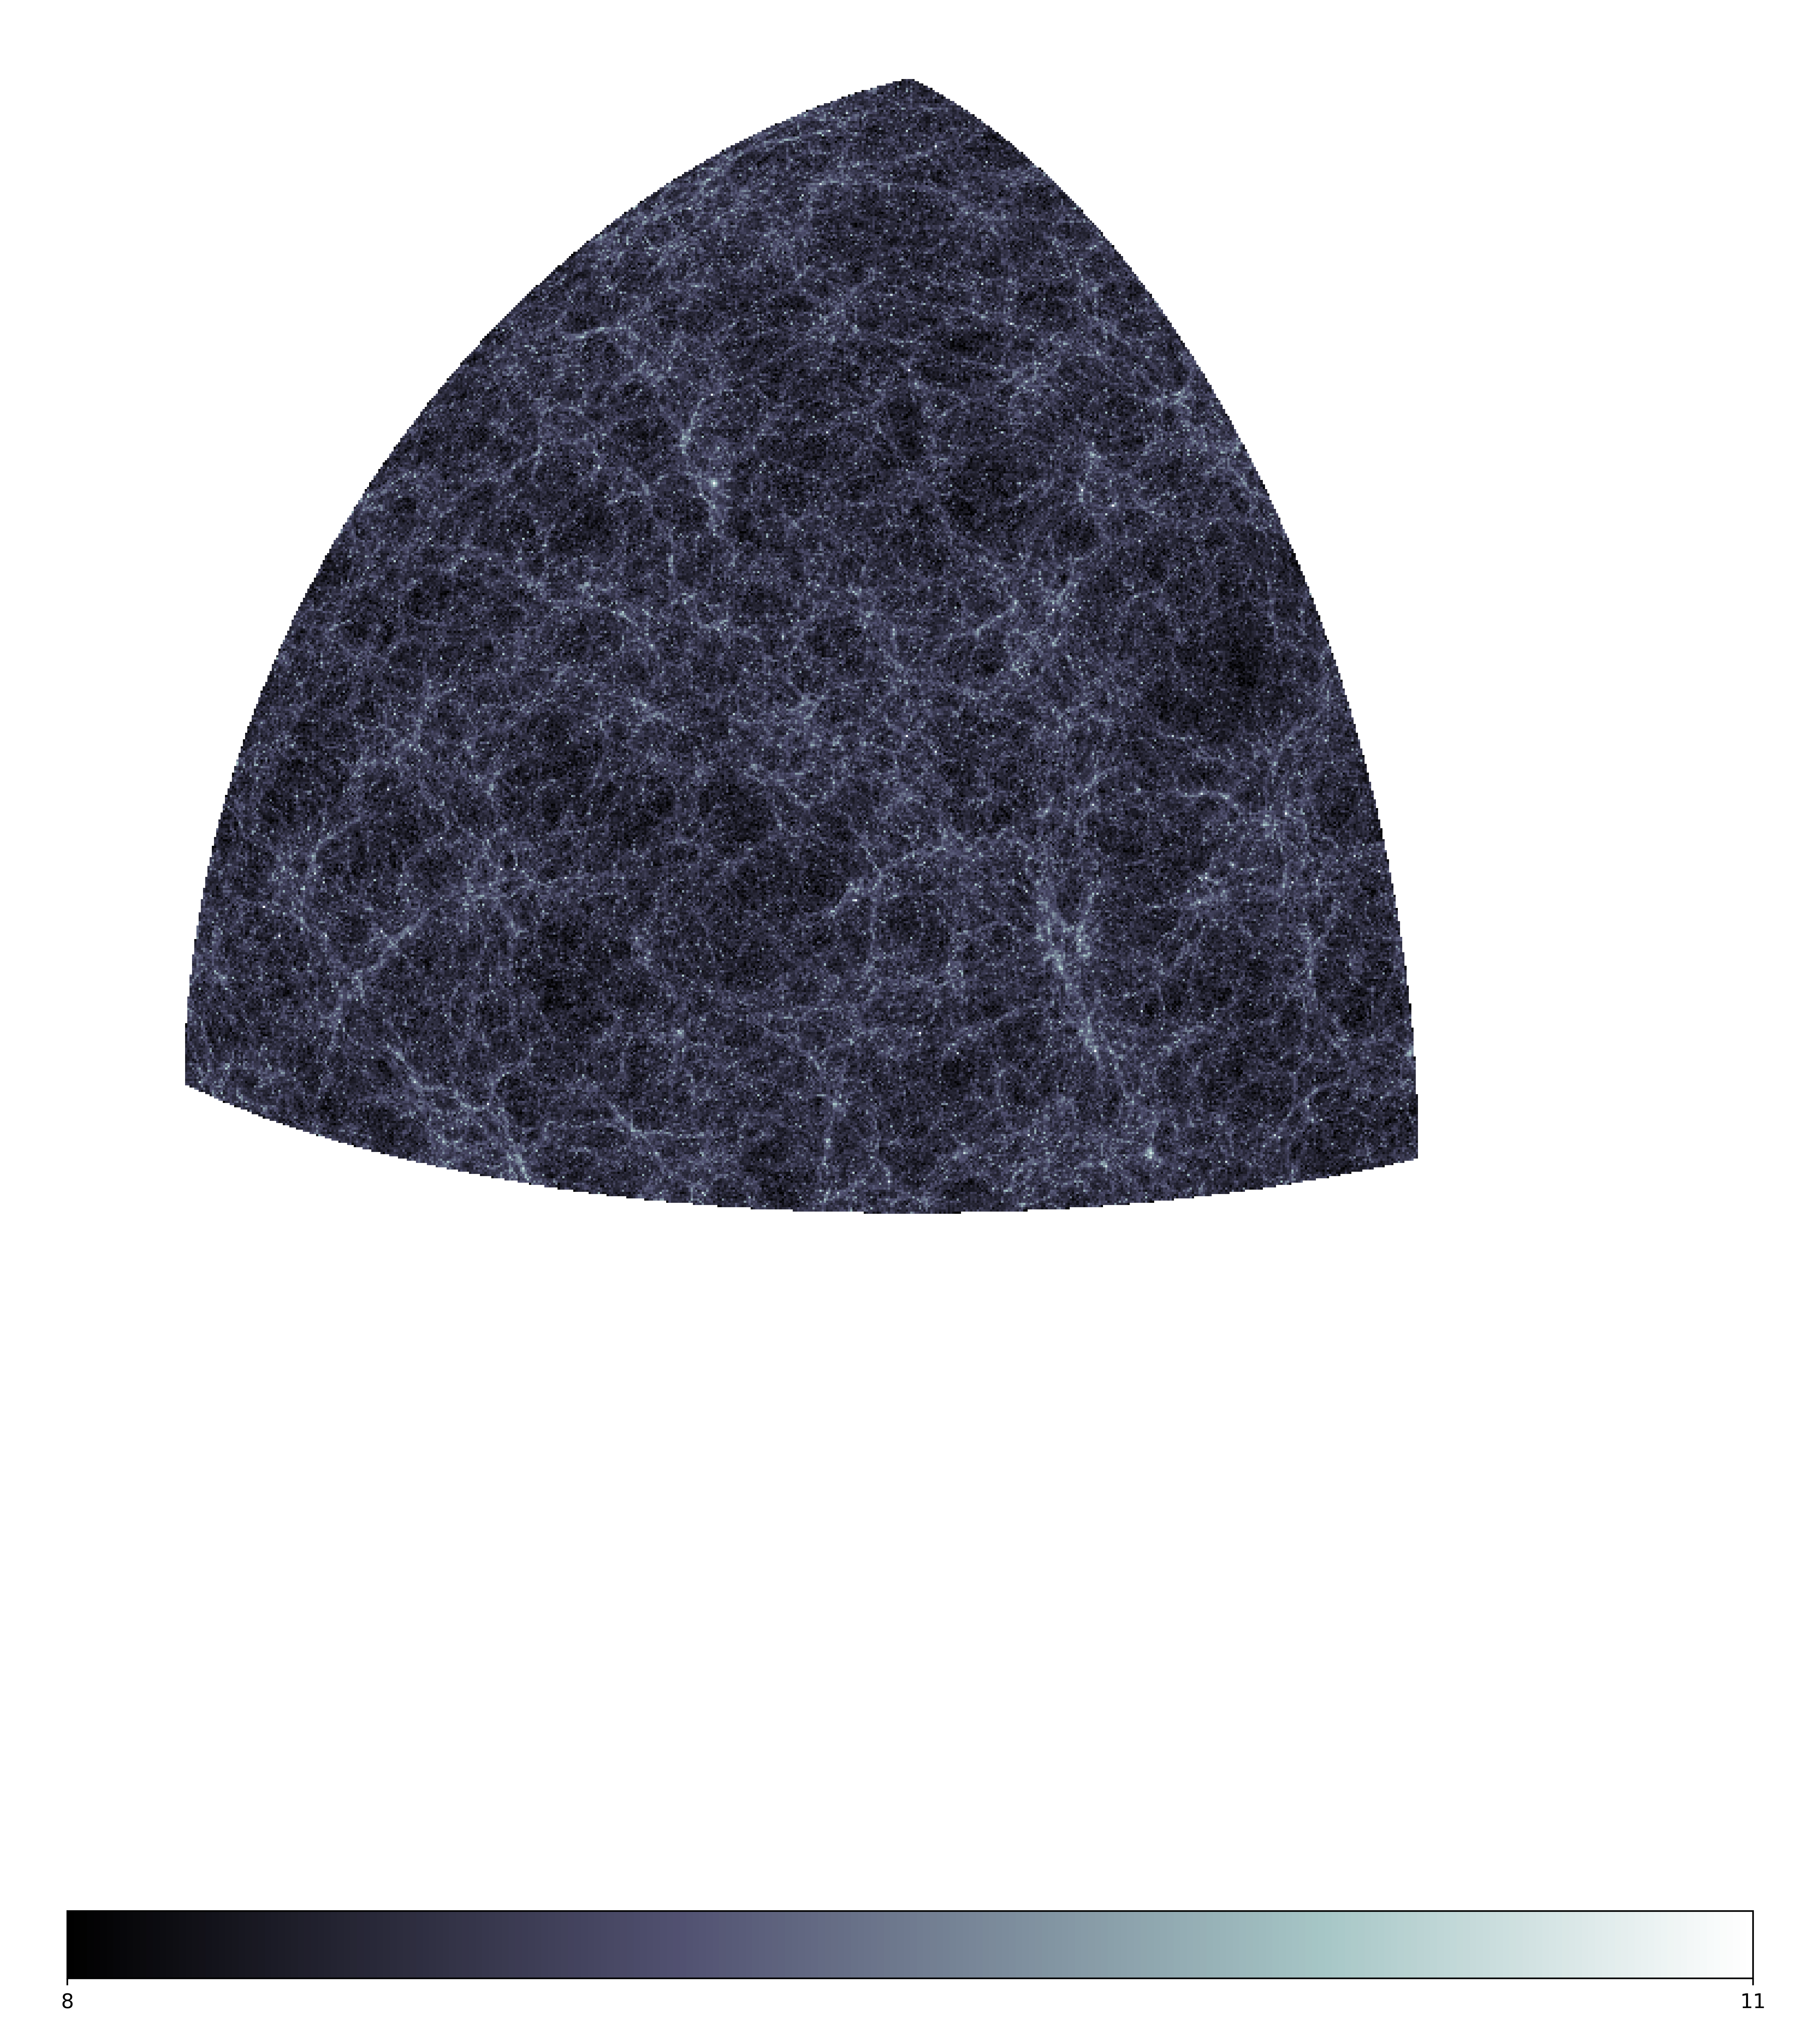

In [48]:



fig=plt.figure(figsize=(24,16), dpi= 400, facecolor='w', edgecolor='k')
hp.orthview(np.log10(binmap*mask+1),rot=(35,20),
                half_sky=True,
                title = None,
                min=8,
                max=11,
                cmap='bone',
                nest=False,
                badcolor='white',
                fig=fig
               )

In [15]:
snap=0
fname = path_out_tidal+'tidal_field_map_'+str(snaplist[snap])+'_allsky_smooth_05Mpc.npy'
#with open(fname, 'rb') as f:
print('opened'+fname)
s=np.load(fname)

fname = 'mask_allsky.npy'
mask= np.load(fname)

opened/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/BCM/dmb_Mc2e14/tidalfield/tidal_field_map_0_allsky_smooth_05Mpc.npy


/tmp/ipykernel_292748/1392695116.py:2: RuntimeWarning: invalid value encountered in log10
  hp.orthview(np.log10(s[:,0]*mask+1),rot=(35,20),


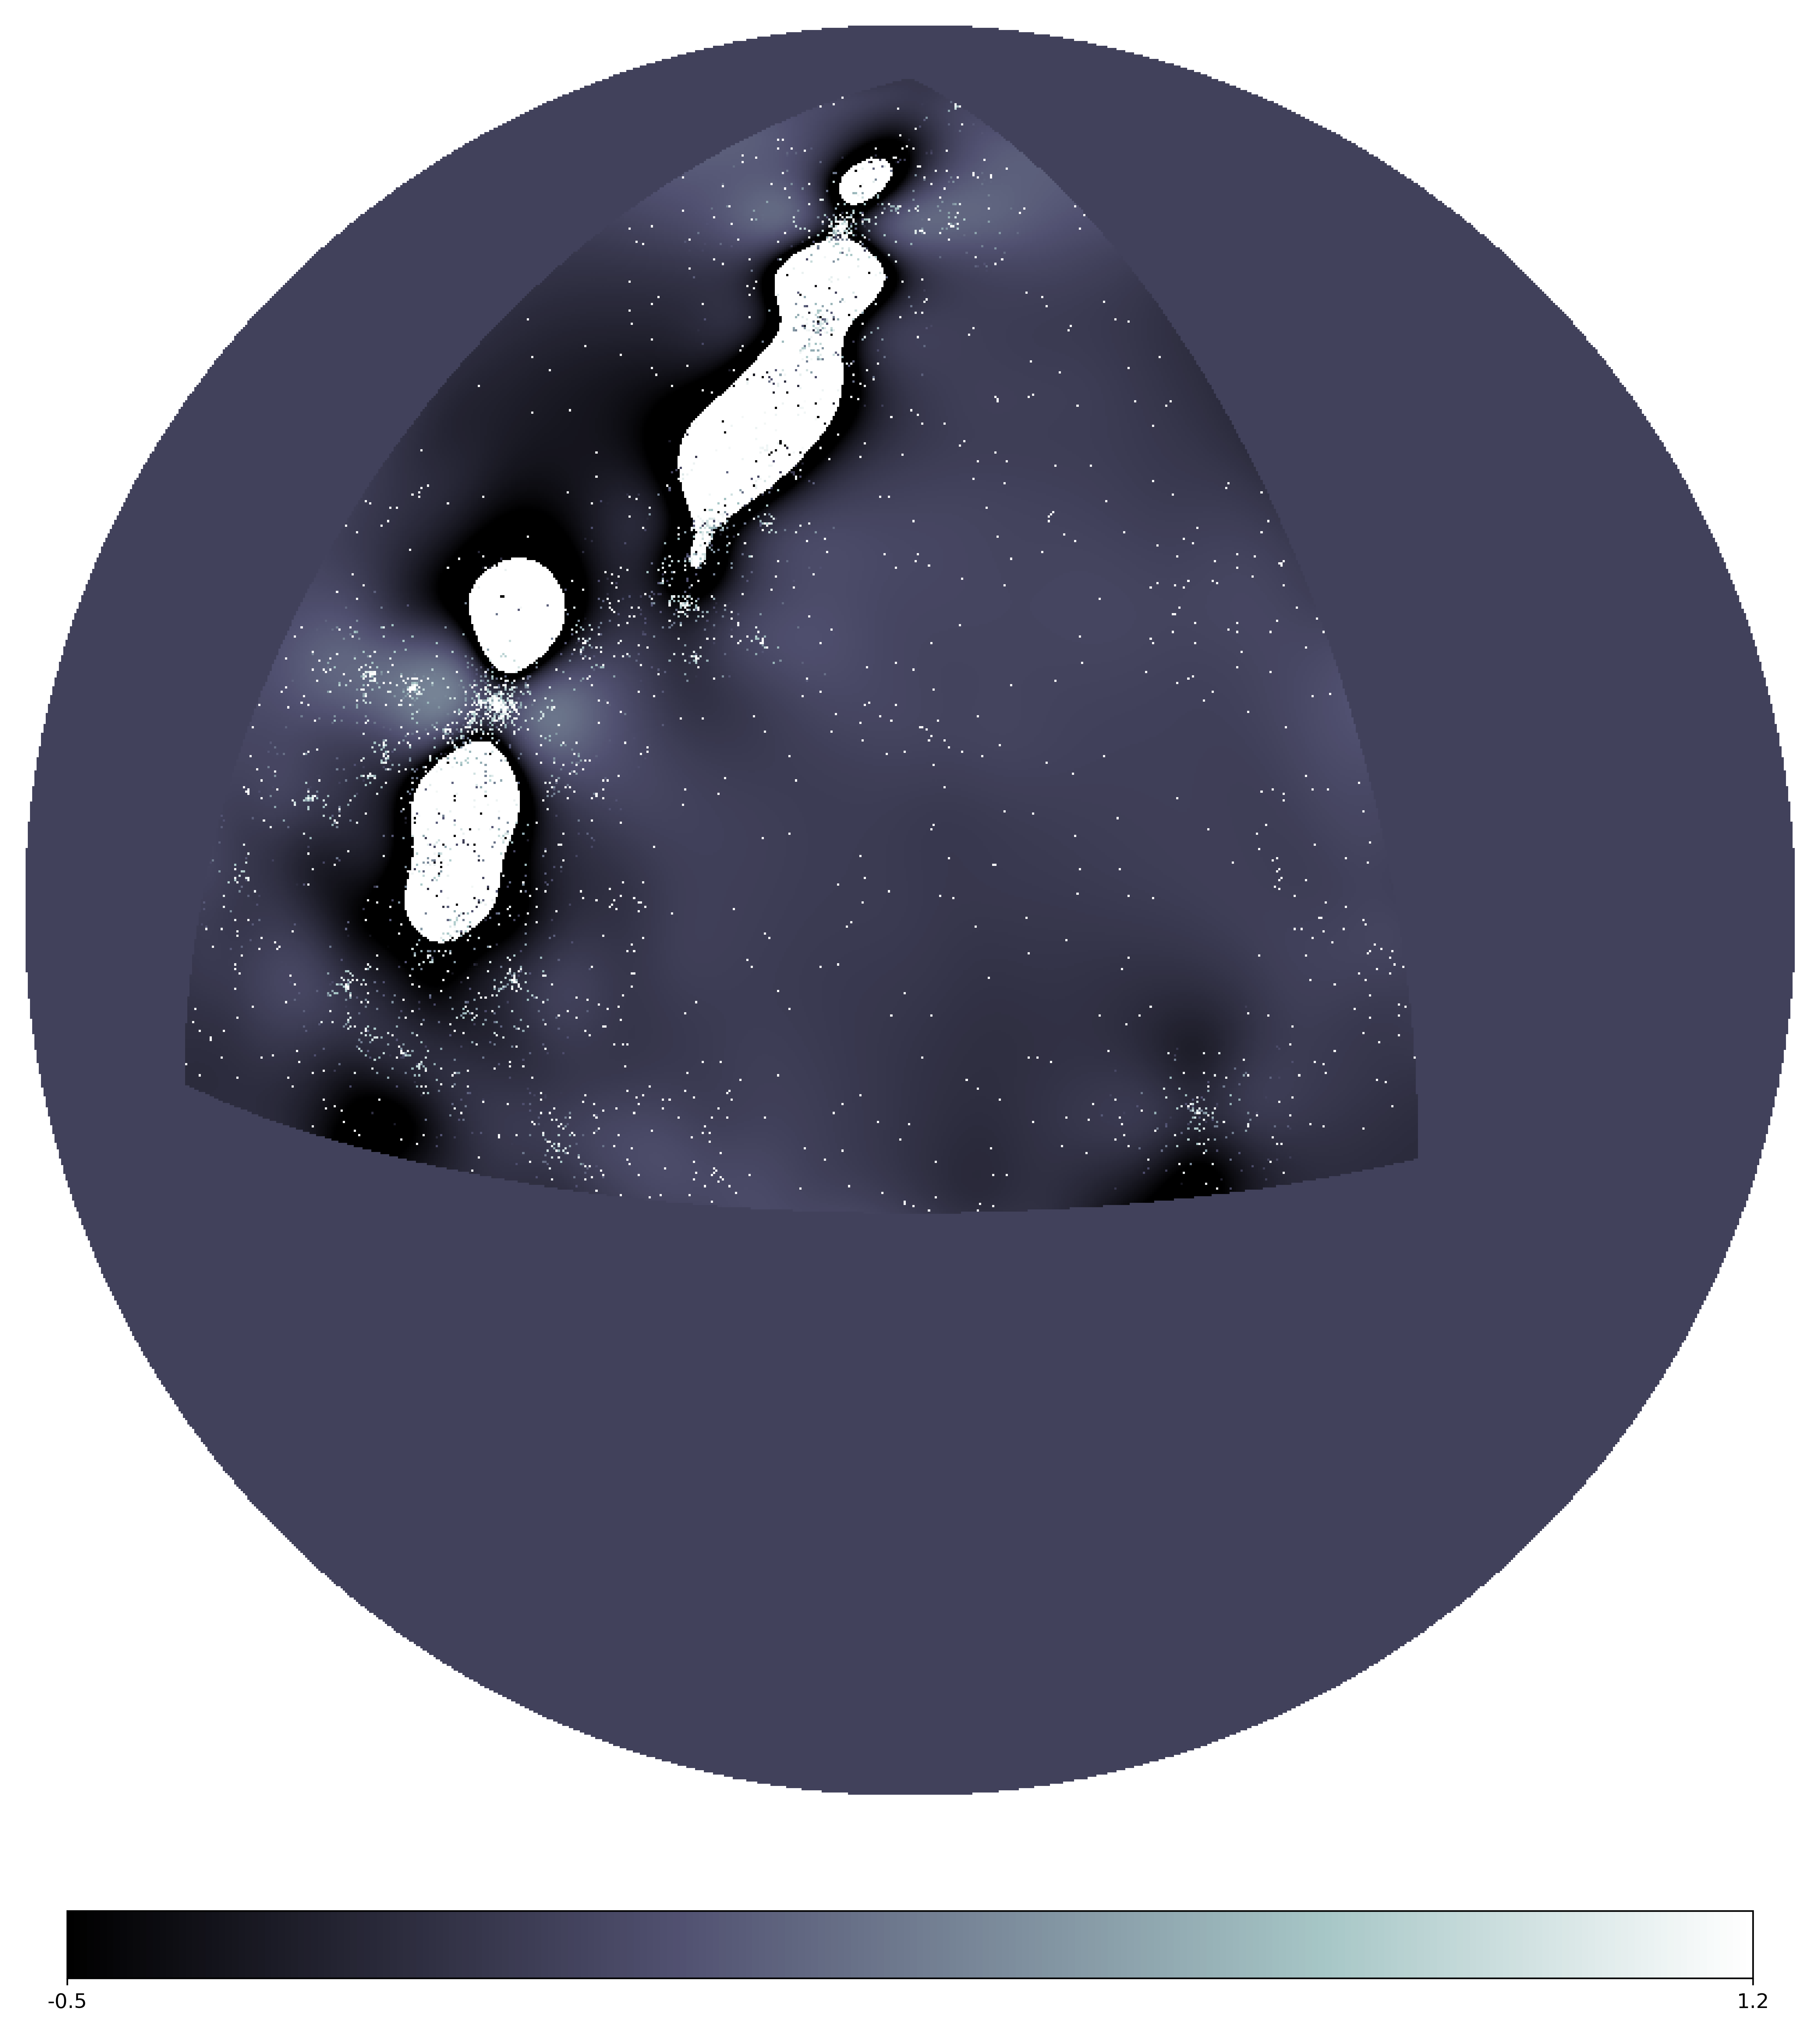

In [16]:
fig=plt.figure(figsize=(24,16), dpi= 400, facecolor='w', edgecolor='k')
hp.orthview(np.log10(s[:,0]*mask+1),rot=(35,20),
                half_sky=True,
                title = None,
                min=-0.5,
                max=1.2,
                cmap='bone',
                nest=False,
                badcolor='white',
                fig=fig
               )

/tmp/ipykernel_292748/2194766158.py:2: RuntimeWarning: invalid value encountered in log10
  hp.orthview(np.log10(s[:,1]*mask+1),rot=(35,20),


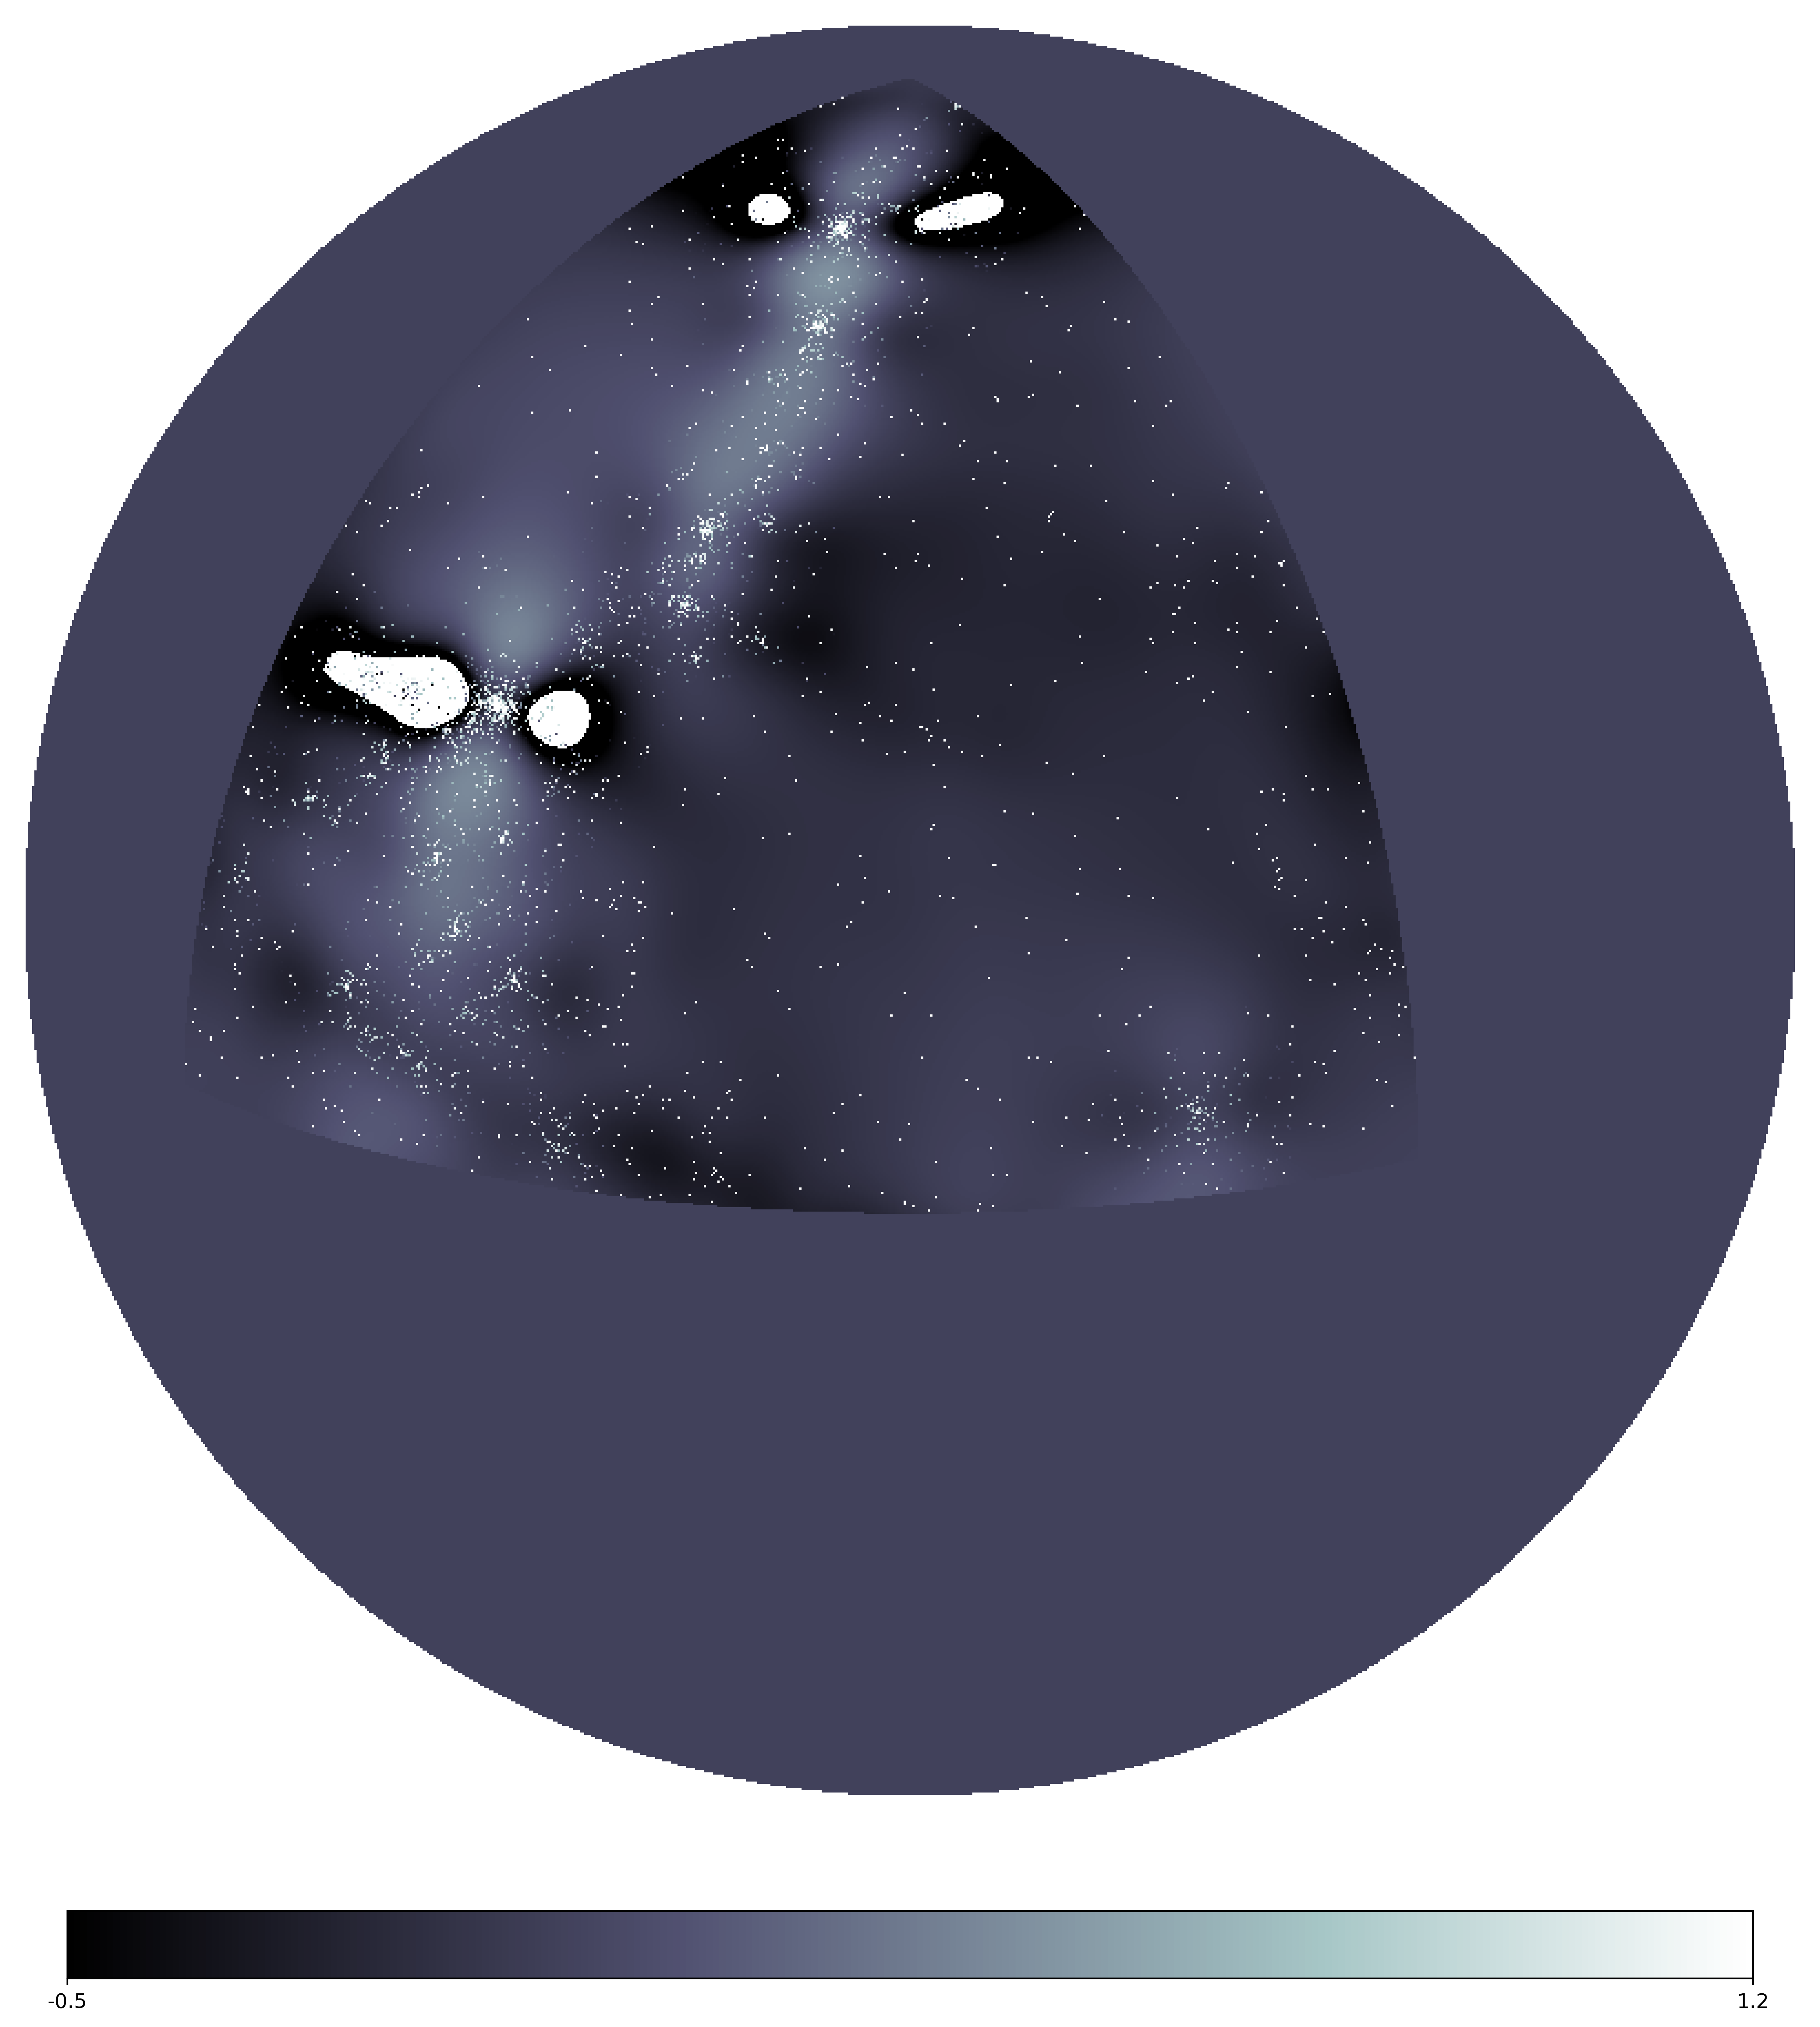

In [17]:
fig=plt.figure(figsize=(24,16), dpi= 400, facecolor='w', edgecolor='k')
hp.orthview(np.log10(s[:,1]*mask+1),rot=(35,20),
                half_sky=True,
                title = None,
                min=-0.5,
                max=1.2,
                cmap='bone',
                nest=False,
                badcolor='white',
                fig=fig
               )

/tmp/ipykernel_292748/1594278407.py:2: RuntimeWarning: invalid value encountered in log10
  hp.orthview(np.log10(s[:,2]*mask+1),rot=(35,20),


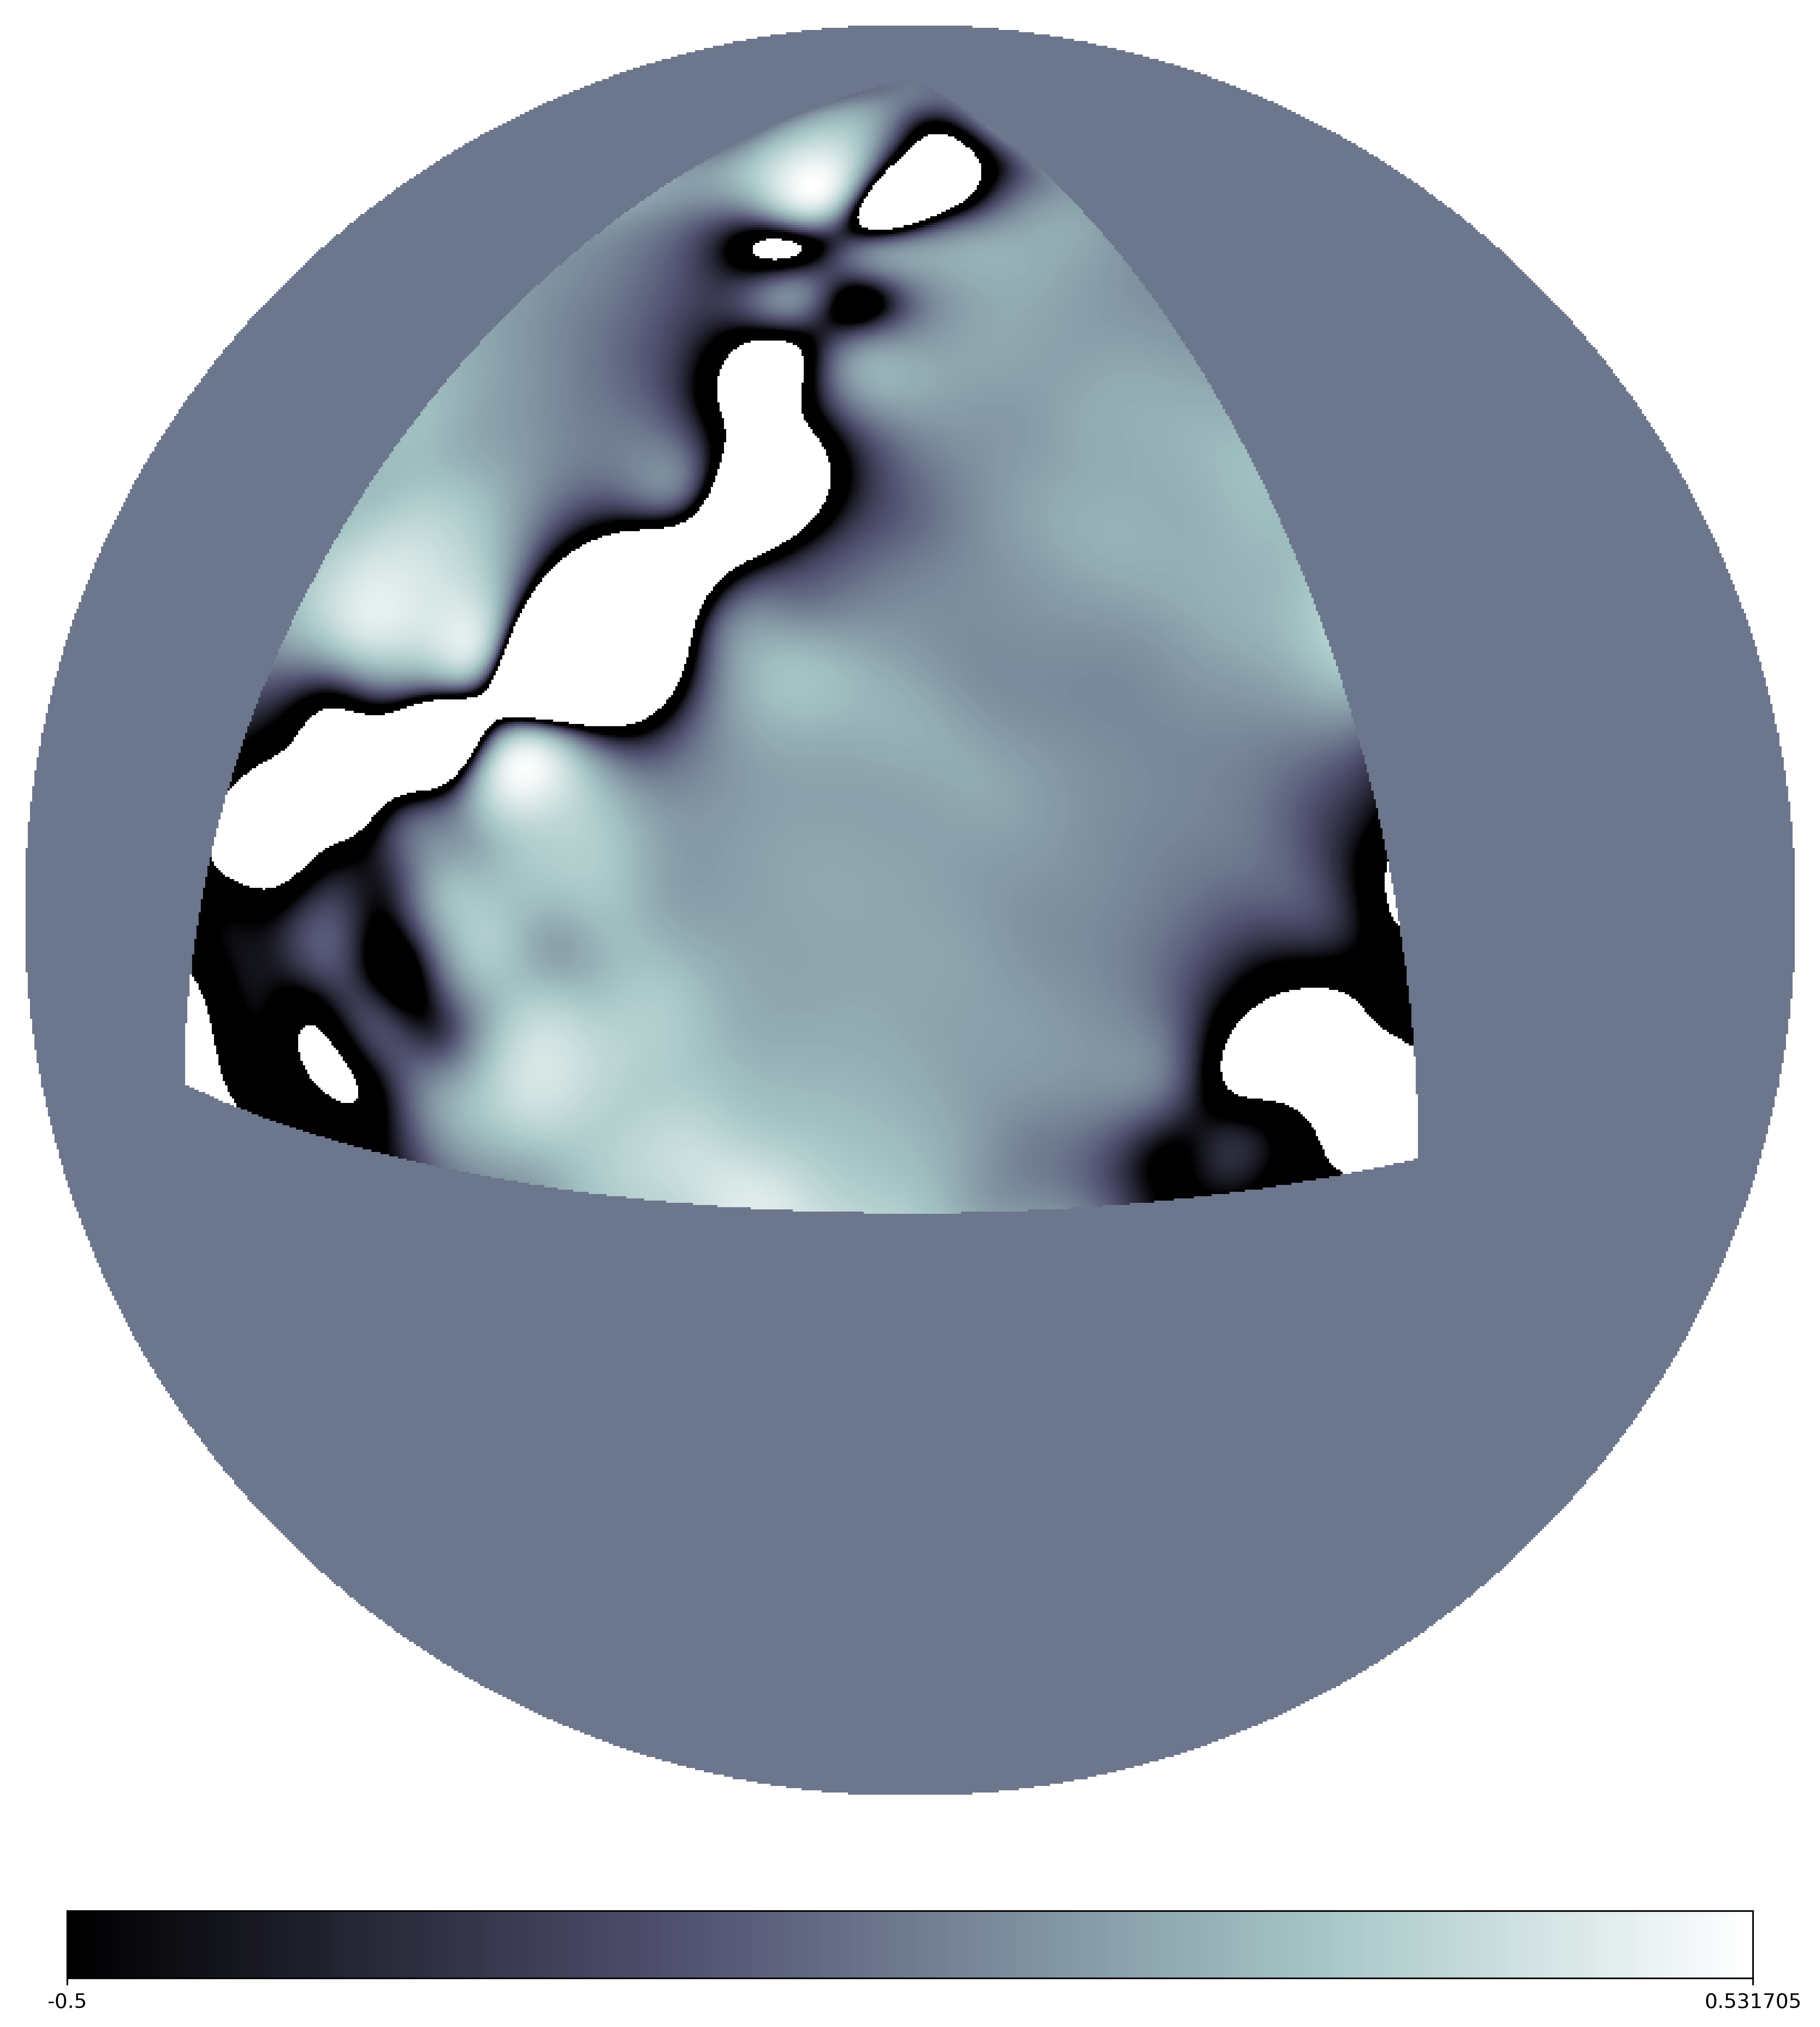

In [18]:
fig=plt.figure(figsize=(24,16), dpi= 400, facecolor='w', edgecolor='k')
hp.orthview(np.log10(s[:,2]*mask+1),rot=(35,20),
                half_sky=True,
                title = None,
                min=-0.5,
                #max=10,
                cmap='bone',
                nest=False,
                badcolor='white',
                fig=fig
               )

In [20]:
s[:,1]*mask

array([-0.16666809, -0.16666809, -0.        , ..., -0.        ,
       -0.        , -0.        ], dtype=float32)